In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
                              voting='hard')

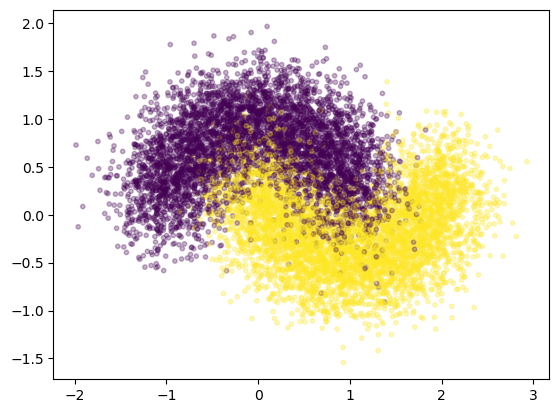

In [2]:
X,y = make_moons(n_samples=10000, noise=0.3)

plt.scatter(X[:,0], X[:,1], s=10, alpha=0.3,c=y)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [4]:
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [5]:
from sklearn.metrics import accuracy_score
for clf in (log_clf,rnd_clf,svm_clf,voting_clf):
    clf.fit(X_train,y_train)
    prediction = clf.predict(X_test)
    print(clf.__class__.__name__,':', accuracy_score(y_test,prediction))

LogisticRegression : 0.849
RandomForestClassifier : 0.8985
SVC : 0.9125
VotingClassifier : 0.908


In [6]:
#Bagging is short for bootstrap and aggregating which is taking from the training set a number of samples with replacement, Pasting is the same but without replacement, if you want pasting, just set bootstrap = False
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)
bag_clf.fit(X_train,y_train)
prediction = bag_clf.predict(X_test)
print('accuracy:', accuracy_score(y_test,prediction))

accuracy: 0.91


In [7]:

#using the out of bag instances (those instances that were not selected in an estimator) one can assess the evaluation score without necessarily separating the set in train and test
bag_clf = BaggingClassifier(DecisionTreeClassifier(), 
                            n_estimators=500, 
                            bootstrap=True, 
                            oob_score=True,
                            max_samples=100,
                            n_jobs=-1)
bag_clf.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True)

In [8]:
oob_score = bag_clf.oob_score_
y_pred = bag_clf.predict(X_test)
print('accuracy_score:', accuracy_score(y_test,y_pred), 'oob score:', oob_score)

accuracy_score: 0.9075 oob score: 0.907625
